# Data analysis

Experiment information:
- One million function evaluations
- **sade_remc**: is the best method from HM, but with more evals
- **sade_mc_final**: is sade + MC + ffi9 + rmsd crowding + spicker + hooke jeeves on cluster centroids
- **sade_remc_final**: is the same as above, but REMC instead of MC
- **sade_mc_ffi9_02**: is HM method + forced fragment insertion of size 2 with 0.02 chance of happening per individal per generation
- **sade_remc_ffi9_02**: same as above but with REMC instead of MC

In [14]:
import datetime
import string
import random
import pickle
import time
import sys
import os
import re

import utils
import data_utils

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid");
plt.style.use('seaborn-whitegrid')

In [15]:
root_path = '/home/h3nnn4n/progs/de_supimpa/tools/notebooks/analysis'
base_path = '/home/h3nnn4n/progs/de_supimpa/src'


def reset_path():
    os.chdir(base_path)
    
    
def reset_to_root_path():
    os.chdir(root_path)

    
reset_to_root_path()
reset_path()

In [16]:
runs = [
    'de_experiment_final',
    'de_sade_remc',
    'de_rosetta',
    'de_ffi',
    'de_experiment_final_8_prot',
    'de_final_1rop_1wqc_1lwy',
    'de_rosetta_all_prots',
    'de_other_experiments_all_prots',
    'de_missing_4_base_prots_runs',
    'de_mc_de-mc_de-remc_4prot',
]

In [17]:
def get_metric_from_data_file(filename, index):
    data = []

    all_data = read_data_from_file(filename)

    for line in all_data:
        data.append(line[index])

    return data


def get_xy_from_data_file(filename, x, y):
    x_data = []
    y_data = []

    data = read_data_from_file(filename)

    for line in data:
        x_data.append(line[x])
        y_data.append(line[y])

    return x_data, y_data


def read_data_from_file(filename):
    data = []
    with open(filename) as f:
        for line in f.readlines():
            tokens = re.sub(r"\s\s+", " ", line).strip().split(' ')
            numbers = list(map(lambda x: parse_num(x), tokens))

            data.append(numbers)

    return data


def parse_num(num):
    try:
        return int(num)
    except BaseException:
        return float(num)
    

def list_stats():
    all_files = [file for file in os.listdir() if os.path.isfile(file) and 'stats__' in file]

    return all_files


def get_all_metric(index):
    all_data = []
    files = list_stats()

    for data_file in files:
        evals, data = get_xy_from_data_file(data_file, metrics['evals'], index)

        all_data.append({
            'evals': evals,
            'data': data
        })

    return all_data


def lerp(a, b, p):
    return (a * p) + ((1 - p) * b)

In [18]:
def average_all(metric):
    all_data = get_all_metric(metric)

    assert len(all_data) > 0, "all_data is [] !"

    target_evals = all_data[0]['evals']
    target_data = []

    assert len(target_evals) > 0, "target_evals is [] !"

    for index, target in enumerate(target_evals):
        target_data.append([])

        for data_pair in all_data:
            assert len(data_pair) > 0, "data_pair is [] !"

            evals, data = data_pair.values()
            evals, data = data_pair['evals'], data_pair['data']

            assert len(evals) > 0, "evals is [] !"
            assert len(data) > 0, "data is [] !"

            for i in range(1, len(evals)):
                a, b = evals[i - 1], evals[i]

                if a == target:
                    target_data[index].append(data[i - 1])
                    break

                if b == target:
                    target_data[index].append(data[i])
                    break

                if a < target and b > target:
                    target_data[index].append(lerp(data[i], data[i - 1], (target - a) / (b - a)))
                    break

            if index == len(target_evals) - 1:
                target_data[index].append(data[i])

    mean = [
        sum(x) / len(x) for x in target_data
    ]

    l = min(len(target_evals), len(mean))

    target_evals = target_evals[0:l]
    mean = mean[0:l]

    return target_evals, mean

In [19]:
allowed_methods=['sade_remc_final', 'sade_mc_final']
protein_blacklist = ['1ab1', '1dfn', '2p5k', '2pmr', '3v1a']


metrics = {
    'evals': 0,
    'iters': 1,
    'best_score': 2,
    'mean_score': 3,
    'pedro_diver': 4,
    'avg_rmsd': 5,
    'best_rmsd': 6,
    'moment_of_inertia': 7
}


def list_contains_substring(container, string):
    return any(map(lambda x: x in string, container))


def find_experiment_folder(run):
    dirs = [f for f in os.listdir() if os.path.isdir(f)]
    exp_folder = [f for f in dirs if list_contains_substring(runs, f)]
    
    if len(exp_folder) > 1:
        raise Exception('Found more than one experiment folder. Aborting\n%s' % exp_folder)
        
    return exp_folder[0]


def load_stats_data():
    os.chdir('stats')
    d = {}
    
    print(os.getcwd().split('/')[-3:-1])
    
    for metric in metrics.keys():
        if metric in ['evals', 'iters']:
            continue
                
        evals, metric_data = average_all(metrics[metric])
        
        d[metric] = {
            'evals': evals,
            'data': metric_data
        }
        
    os.chdir('..')
    
    return d


def load_data():
    reset_path()
 
    data_stats = {}
    
    for run in runs:
        os.chdir(run)
        
        exp_folder = find_experiment_folder(run)
        os.chdir(exp_folder)
        
        protein_folders = [f for f in os.listdir() if len(f) == 4 and os.path.isdir(f)]
        
        for pf in protein_folders:
            if pf in protein_blacklist:
                continue
            
            os.chdir(pf)
            if pf not in data_stats.keys():
                data_stats[pf] = {}
            
            for exp in os.listdir():
                if exp not in allowed_methods:
                    continue
                    
                os.chdir(exp)
               
                data_stats[pf][exp] = load_stats_data()
                
                os.chdir('..')
            
            os.chdir('..')
        
        os.chdir('..')
        os.chdir('..')
        
    return data_stats

In [20]:
data_stats = load_data()
print('finished')

def rename_methods(data, renamer={}):
    proteins = sorted(list(data.keys()))

    for protein in proteins:
        methods = sorted(list(data[protein].keys()))
        
        for method in methods:
            if method in renamer.keys():
                tmp = data[protein].pop(method)
                data[protein][renamer[method]] = tmp


rename_methods(data_stats, renamer={'sade_remc_final': 'ppf-remc', 'sade_mc_final': 'ppf-mc'})

['1ail', 'sade_remc_final']
['1ail', 'sade_mc_final']
['1zdd', 'sade_remc_final']
['1zdd', 'sade_mc_final']
['1enh', 'sade_remc_final']
['1enh', 'sade_mc_final']
['1crn', 'sade_remc_final']
['1crn', 'sade_mc_final']
['2mr9', 'sade_remc_final']
['2mr9', 'sade_mc_final']
['1ail', 'sade_remc_final']
['1ail', 'sade_mc_final']
['1utg', 'sade_remc_final']
['1utg', 'sade_mc_final']
['1zdd', 'sade_remc_final']
['1zdd', 'sade_mc_final']
['1enh', 'sade_remc_final']
['1enh', 'sade_mc_final']
['1acw', 'sade_remc_final']
['1acw', 'sade_mc_final']
['1crn', 'sade_remc_final']
['1crn', 'sade_mc_final']
['1rop', 'sade_remc_final']
['1rop', 'sade_mc_final']
['1wqc', 'sade_remc_final']
['1wqc', 'sade_mc_final']
['1l2y', 'sade_remc_final']
['1l2y', 'sade_mc_final']
['1ail', 'sade_remc_final']
['1ail', 'sade_mc_final']
['1zdd', 'sade_remc_final']
['1zdd', 'sade_mc_final']
['1enh', 'sade_remc_final']
['1enh', 'sade_mc_final']
['1crn', 'sade_remc_final']
['1crn', 'sade_mc_final']
finished


## Plots

In [21]:
def interpolate_data(data, protein, metric):
    method_a = 'ppf-mc'
    method_b = 'ppf-remc'

    data_a = data[protein][method_a][metric]
    data_b = data[protein][method_b][metric]

    interpolated = {
        'evals': [],
        method_a: [],
        method_b: []
    }

    if len(data_a['evals']) < len(data_b['evals']):
        t = data_a
        data_a = data_b
        data_b = t

    pivot = 0

    for index, d in enumerate(data_a['evals']):
        interpolated['evals'].append(d)
        interpolated[method_a].append(data_a['data'][index])
        interpolated[method_b].append(eval_at_point(data_b, d))
        
    return interpolated


def eval_at_point(data, point):
    for i in range(len(data['evals']) - 1):
        data_point = data['evals'][i]
        next_point = data['evals'][i+1]
        
        if point == data_point or (i == 0 and point < data_point):
            return data['data'][i]
        
        if data_point < point and point < next_point:
            return lerp(
                data['data'][i],
                data['data'][i + 1],
                (point - next_point) / (data_point - next_point)
            )
        
        if i == len(data['evals']) - 2:
            return data['data'][-1]
    
    return 0

In [29]:
sns.set(style="whitegrid");
plt.style.use('seaborn-whitegrid')

In [37]:
def plot_compare_energy(data, protein):
    method_a = 'ppf-mc'
    method_b = 'ppf-remc'
    
    best_score_data = interpolate_data(data, protein, 'best_score')
    evals_ax1 = best_score_data['evals']
    best_score_a = best_score_data[method_a]
    best_score_b = best_score_data[method_b]
    
    mean_score_data = interpolate_data(data, protein, 'mean_score')
    evals_ax2 = mean_score_data['evals']
    mean_score_a = mean_score_data[method_a]
    mean_score_b = mean_score_data[method_b]
    
    fig = plt.figure(figsize=(16.5, 10))
    ax = plt.axes()
    
    ax.plot(evals_ax1, best_score_a, 'r', label='%s' % method_a.upper(), linewidth=4, marker=None)
    ax.plot(evals_ax1, best_score_b, 'b', label='%s' % method_b.upper(), linewidth=4, marker=None)

    ax.plot(evals_ax2, mean_score_a, 'r', label='%s' % method_a.upper(), linewidth=4, linestyle='-.')
    ax.plot(evals_ax2, mean_score_b, 'b', label='%s' % method_b.upper(), linewidth=4, linestyle='-.')

    ax.set_xlabel('Evals', fontsize=32)
    ax.set_ylabel('Score3', fontsize=32)
    
    ax.set_xlim(0, 1000000)
    ax.set_ylim(bottom=0)
    
    ax.tick_params(labelsize=25)
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.8, 0.8), prop={'size': 32}, frameon=True)
    plt.title('Energy convergence for %s' % (protein), fontsize=50)

    name = "energy_convergence_%s.pdf" % (
        protein
    )
    
    plt.savefig(name)
    
    return fig

In [38]:
def plot_compare_rmsd(data, protein):
    method_a = 'ppf-mc'
    method_b = 'ppf-remc'
    
    best_score_data = interpolate_data(data, protein, 'avg_rmsd')
    evals_ax1 = best_score_data['evals']
    best_score_a = best_score_data[method_a]
    best_score_b = best_score_data[method_b]
    
#     mean_score_data = interpolate_data(data, protein, 'mean_score')
#     evals_ax2 = mean_score_data['evals']
#     mean_score_a = mean_score_data[method_a]
#     mean_score_b = mean_score_data[method_b]
    
    fig = plt.figure(figsize=(16.5, 10))
    ax = plt.axes()
    
    ax.plot(evals_ax1, best_score_a, 'r', label='%s' % method_a.upper(), linewidth=4, marker=None)
    ax.plot(evals_ax1, best_score_b, 'b', label='%s' % method_b.upper(), linewidth=4, marker=None)

#     ax.plot(evals_ax2, mean_score_a, 'r', label='%s' % method_a.upper(), linestyle='-.')
#     ax.plot(evals_ax2, mean_score_b, 'b', label='%s' % method_b.upper(), linestyle='-.')

    ax.set_xlabel('Evals', fontsize=32)
    ax.set_ylabel('Average RMSD', fontsize=32)
    
    ax.set_xlim(0, 1000000)
    ax.set_ylim(bottom=0)
    
    ax.tick_params(labelsize=25)
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.8, 0.8), prop={'size': 32}, frameon=True)
    plt.title('Average pairwise RMSD for %s' % (protein), fontsize=50)

    name = "avg_rmsd_%s.pdf" % (
        protein
    )
    
    plt.savefig(name)
    
    return fig

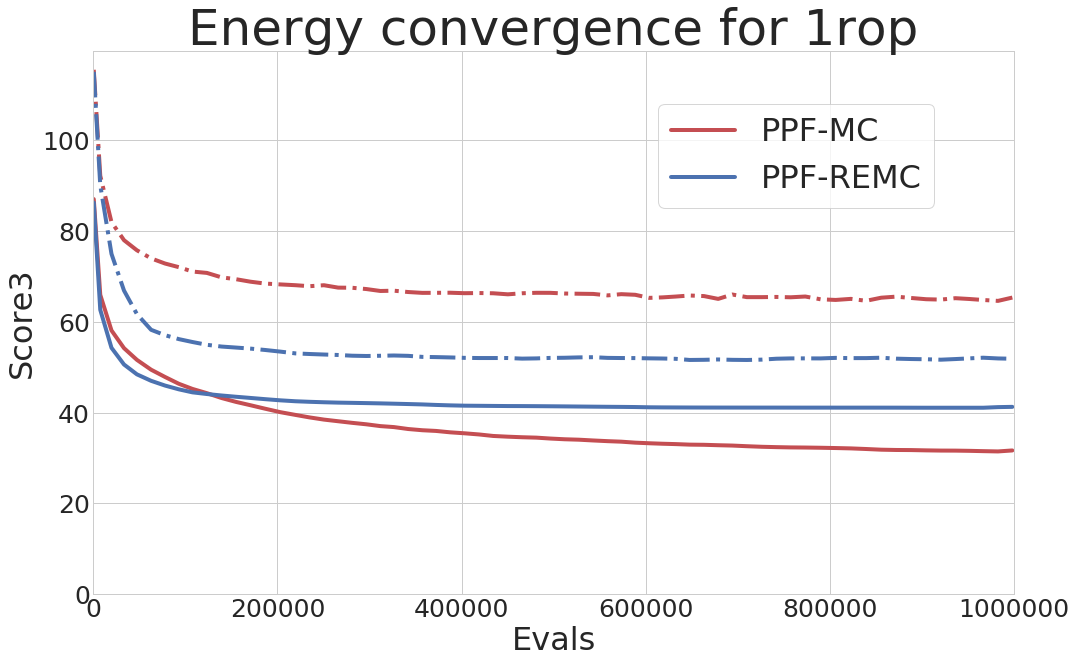

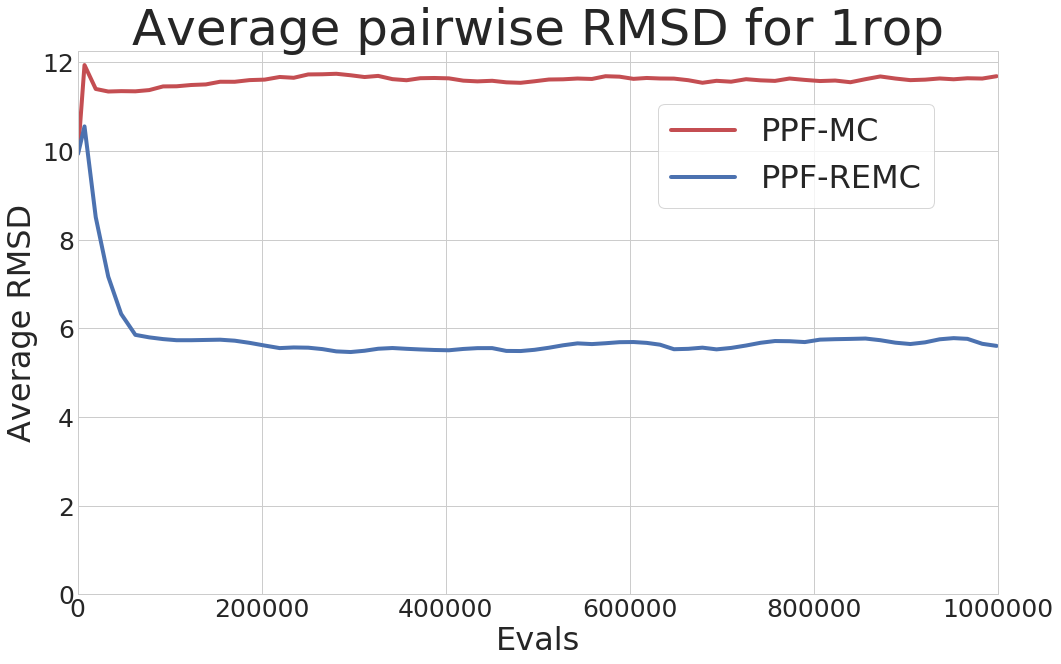

In [40]:
plot_compare_energy(data_stats, '1rop');
plot_compare_rmsd(data_stats, '1rop');

In [41]:
for protein in data_stats.keys():
    plot_compare_energy(data_stats, protein).clear();
    plot_compare_rmsd(data_stats, protein).clear();
    
plt.clf()